### 環境確認

In [ ]:
import sys
import torch

print("Pythonのバージョン：",sys.version)
print("PyTorchのバージョン：", torch.__version__)
print("使用しているGPUの確認")
!nvidia-smi

Pythonのバージョン： 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
PyTorchのバージョン： 1.11.0+cu113
使用しているGPUの確認
Sun Jun 26 11:18:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----

In [ ]:
!wget -q http://imgcom.jsrt.or.jp/imgcom/wp-content/uploads/2019/07/segmentation02.zip

In [ ]:
# 解凍
!unzip -q /content/segmentation02.zip

In [ ]:
!ls

model  sample_data  segmentation02  segmentation02.zip


### 事前準備

In [ ]:
import os

# 初期設定
COLAB_FLG = False # COLABで実行する場合はTrue, それ以外で実行する場合はFalse

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = '/content/gdrive/MyDrive/Xray_segmentation'  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = '.'  # ローカルならカレントディレクトリ
    
    
SAVE_MODEL_PATH = f'{ATTACH_PATH}/model/'  # モデルの保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

In [ ]:
# ライブラリのインストール
!pip install -q pytorch_lightning
!pip install -q torchmetrics==0.6.0

In [ ]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import argparse

import PIL
from PIL import Image

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torchmetrics
from torchmetrics.functional import accuracy, iou

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3

In [ ]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--image_size', type=int, default=256)
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--lr', type=float, default=1e-4) # 学習率
parser.add_argument('--patience', type=int, default=10) # earlystoppingの監視対象回数
param = parser.parse_args(args=[])
print(param)

Namespace(batch_size=4, epochs=100, image_size=256, lr=0.0001, patience=10)


### データの準備

In [ ]:
# 画像ファイル名リスト
train_img_list = sorted(glob('/content/segmentation02/segmentation/org_train/*.bmp'))
test_img_list = sorted(glob('/content/segmentation02/segmentation/org_test/*.bmp'))

# ラベル画像リスト
train_label_list = sorted(glob('/content/segmentation02/segmentation/label_train/*.png'))
test_label_list = sorted(glob('/content/segmentation02/segmentation/label_test/*.png'))

### Dataset クラスの定義

In [ ]:
class XrayDataset(data.Dataset):

    def __init__(self, img_path_list, label_path_list):
        self.image_path_list = img_path_list
        self.label_path_list = label_path_list
        self.transform = transforms.Compose( [transforms.Resize((param.image_size, param.image_size)),
                                              transforms.ToTensor(),])


    def __len__(self):
        return len(self.image_path_list)

    
    def __getitem__(self, idx):
        img = Image.open(self.image_path_list[idx]).convert('RGB')
        img = self.transform(img)

        label = Image.open(self.label_path_list[idx])
        label = self.transform(label)


        return img, label

In [ ]:
# Datasetのインスタンス作成
train_dataset = XrayDataset(train_img_list, train_label_list)
test_dataset = XrayDataset(test_img_list, test_label_list)

In [ ]:
# datasetの確認
len(train_dataset), len(test_dataset)

(199, 48)

In [ ]:
# 1 サンプル目の入力値と目標値を取得
x, t = train_dataset[0]

# imageのshapeを確認
x.shape, t.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [ ]:
# Dataloader
dataloader = {
    'train': data.DataLoader(train_dataset, batch_size=param.batch_size, shuffle=True),
    'val': data.DataLoader(test_dataset, batch_size=param.batch_size, shuffle=False)
}

### ネットワークの定義と訓練

In [ ]:
class Net(pl.LightningModule):

    def __init__(self, lr: float):
        super().__init__()

        self.lr = lr

        self.model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
        self.model.classifier = deeplabv3.DeepLabHead(2048, 1)


    def forward(self, x):
        h = self.model(x)
        return h


    def training_step(self, batch, batch_idx):
        x, t = batch
        out = self(x)
        y = torch.sigmoid(out['out'])
        loss = F.binary_cross_entropy_with_logits(out['out'], t)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', accuracy(y, t.int()), on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou(y, t.int()), on_step=True, on_epoch=True, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, t = batch
        out = self(x)
        y = torch.sigmoid(out['out'])
        loss = F.binary_cross_entropy_with_logits(out['out'], t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y, t.int()), on_step=False, on_epoch=True)
        self.log('val_iou', iou(y, t.int()), on_step=True, on_epoch=True, prog_bar=True)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [ ]:
# callbacksの定義
model_checkpoint = ModelCheckpoint(
    SAVE_MODEL_PATH,
    filename="DeepLabV3_resnet101"+"{epoch:02d}-{val_loss:.2f}",
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=False,
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=param.patience,
)

In [ ]:
# 訓練の実行
pl.seed_everything(0)
net = Net(lr=param.lr)
trainer = pl.Trainer(max_epochs=param.epochs, 
                     callbacks=[model_checkpoint, early_stopping], 
                     gpus=1)
trainer.fit(net, dataloader['train'], dataloader['val'])

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | DeepLabV3 | 61.0 M
------------------------------------
61.0 M    Trainable params
0         Non-trainable params
61.0 M    Total params
243.964   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# 訓練データと検証データに対する最終的な結果を表示
trainer.callback_metrics

{'train_acc': tensor(0.5125),
 'train_acc_epoch': tensor(0.5125),
 'train_acc_step': tensor(0.5483),
 'train_iou': tensor(0.3414),
 'train_iou_epoch': tensor(0.3414),
 'train_iou_step': tensor(0.3765),
 'train_loss': tensor(0.4154),
 'train_loss_epoch': tensor(0.4154),
 'train_loss_step': tensor(0.3964),
 'val_acc': tensor(0.4935),
 'val_iou': tensor(0.3244),
 'val_iou_epoch': tensor(0.3244),
 'val_loss': tensor(0.4355)}

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

### 結果の可視化

In [ ]:
#net = Net.load_from_checkpoint('/content/model/DeepLabV3_resnet101epoch=20-val_loss=0.05.ckpt', lr=param.lr)

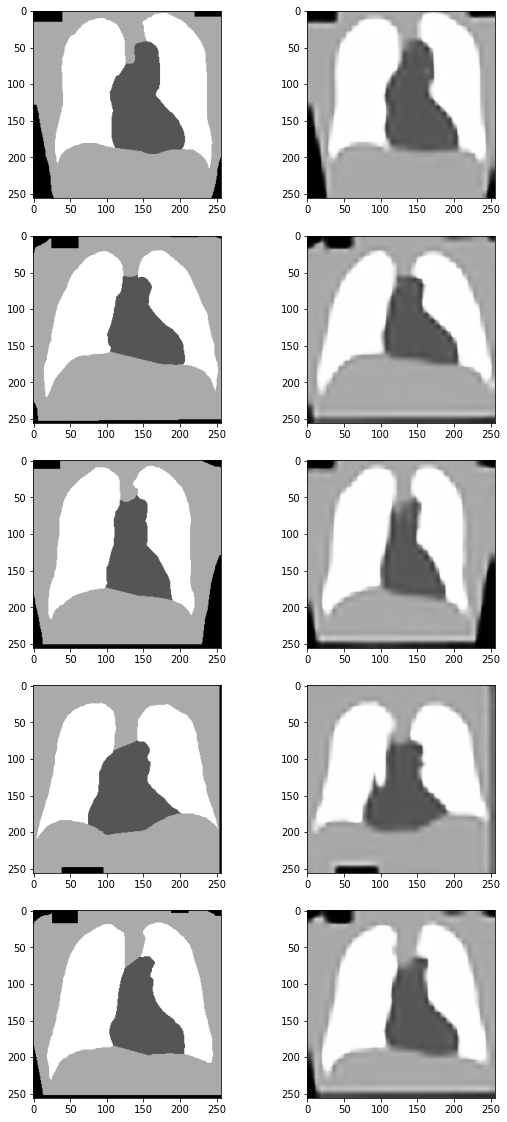

In [ ]:
# 表示する画像サイズ
n_max_imgs = 5

plt.figure(figsize=(9, 20))
for n in range(n_max_imgs):
    x, t = test_dataset[n]
    net.eval()
    out = net(x.unsqueeze(0)) # 最初の位置（0）に新たな次元を挿入
    y_sigmoid = torch.sigmoid(out['out']).detach().numpy()
    y_sigmoid2 = (y_sigmoid * 255).astype(np.uint8)
    y_label = y_sigmoid2.squeeze()
    #print(y_label)

    t = np.squeeze(t) # numpyでtensorの余分な次元を除去

    plt.subplot(n_max_imgs, 2, 2*n+1)
    plt.imshow(t, cmap='gray')

    plt.subplot(n_max_imgs, 2, 2*n+2)
    plt.imshow(y_label, cmap='gray')